In [1]:
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, TimeDistributed, MaxPooling2D, LSTM 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
#from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import pandas as pd
import cv2
import os

import numpy as np

Using TensorFlow backend.


In [2]:
img_height , img_width = 64, 64
seq_len = 250
 
classes = ["0","1"]

In [3]:
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

In [4]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [5]:
X, Y = create_data("video_input/")


0
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
1
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

In [7]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64, 5, activation='relu', padding='same', name='conv1'), input_shape=(seq_len, img_height, img_width, 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='pool1')))

model.add(TimeDistributed(Conv2D(128, 5, activation='relu', name='conv2')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='pool2')))

model.add(TimeDistributed(Conv2D(256, 5, activation='relu', name='conv3')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='pool3')))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))

model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(2, activation='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 250, 64, 64, 64)   4864      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 250, 32, 32, 64)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 250, 28, 28, 128)  204928    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 250, 14, 14, 128)  0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 250, 10, 10, 256)  819456    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 250, 5, 5, 256)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 250, 6400)        

In [8]:
opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [9]:
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]

In [10]:
history = model.fit(x = X_train, y = y_train, epochs=10, batch_size = 8 , shuffle=True, validation_split=0.2, callbacks=callbacks)

Train on 115 samples, validate on 29 samples
Epoch 1/10
115/115 [==============================] - 1428s 12s/step - loss: 0.7049 - accuracy: 0.5304 - val_loss: 0.6829 - val_accuracy: 0.6552
Epoch 2/10
115/115 [==============================] - 1396s 12s/step - loss: 0.7194 - accuracy: 0.4783 - val_loss: 0.7251 - val_accuracy: 0.4828
Epoch 3/10
115/115 [==============================] - 1406s 12s/step - loss: 0.7460 - accuracy: 0.4609 - val_loss: 0.6497 - val_accuracy: 0.6552
Epoch 4/10
115/115 [==============================] - 1415s 12s/step - loss: 0.6754 - accuracy: 0.5478 - val_loss: 0.6572 - val_accuracy: 0.6207
Epoch 5/10
115/115 [==============================] - 1409s 12s/step - loss: 0.7242 - accuracy: 0.4696 - val_loss: 0.6955 - val_accuracy: 0.5517
Epoch 6/10
115/115 [==============================] - 1408s 12s/step - loss: 0.7005 - accuracy: 0.5217 - val_loss: 0.6760 - val_accuracy: 0.6207
Epoch 7/10
115/115 [==============================] - 1404s 12s/step - loss: 0.7314 -

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)


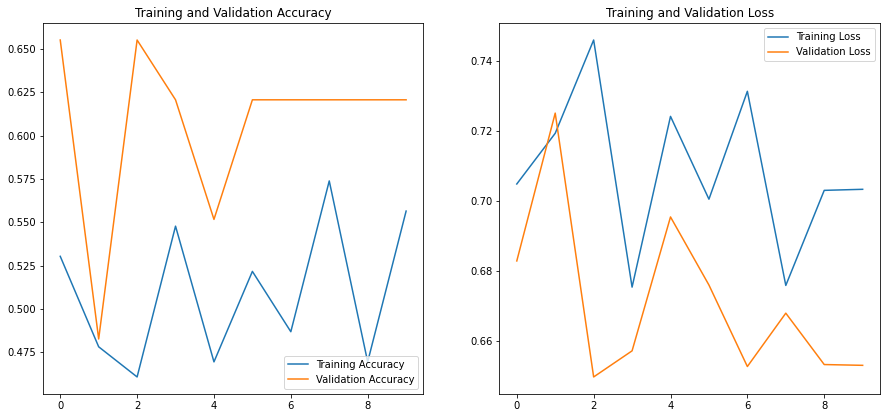

In [12]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()